In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height: 999999999999 in;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
%matplotlib inline
import ast
import os
import os.path as osp
from glob import glob

from IPython.display import display, Image, Markdown
from ipywidgets import interact, interactive
import ipywidgets as widgets 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pickle
from tensorflow.python.summary.summary_iterator import summary_iterator

from attackgraph import settings
import attackgraph.gambit_analysis as gambit_ops
import attackgraph.common.plot_ops as plot_ops

np.set_printoptions(precision=2)
RESULTS_DIR = settings.get_results_dir()

In [16]:
def parse_metrics_from_event(run_name):    
    # Find event file.
    event_file = max(glob(osp.join(RESULTS_DIR, run_name, "events.*")), key=os.path.getctime)
    print(f"Loading: {event_file}")

    # Collect all of the event file data.
    # We will pre-fix each value with the time-stamp because 
    # the summary data has no ordering guarantees.
    metrics = {}    
    for event in summary_iterator(event_file):
        t = event.step
        
        for value in event.summary.value:
            if value.tag not in metrics:
                metrics[value.tag] = []
            metrics[value.tag] += [(t, value.simple_value)]
        
        if t > 50000:
            break
        
    # Sort each metric by timestep.
    for metric, values in metrics.items():
        values = sorted(values, key=lambda x: x[1])
        values = [x[1] for x in values]
        metrics[metric] = values
    
    return metrics

In [17]:
metrics = [parse_metrics_from_event(f"10_29_classify_{i}") for i in range(5)]

Loading: /home/mxsmith/projects/attack_graph/attackgraph/../results/10_25_distill_0/events.out.tfevents.1572011072.rldl10
Loading: /home/mxsmith/projects/attack_graph/attackgraph/../results/10_25_distill_1/events.out.tfevents.1572011075.rldl10
Loading: /home/mxsmith/projects/attack_graph/attackgraph/../results/10_25_distill_2/events.out.tfevents.1572011072.rldl10
Loading: /home/mxsmith/projects/attack_graph/attackgraph/../results/10_25_distill_3/events.out.tfevents.1572011073.rldl10
Loading: /home/mxsmith/projects/attack_graph/attackgraph/../results/10_25_distill_4/events.out.tfevents.1572011072.rldl10


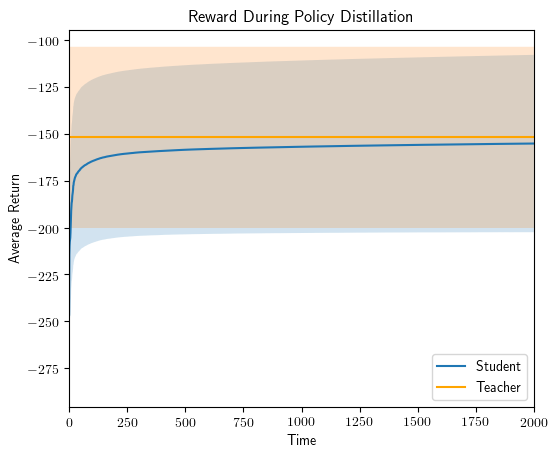

In [22]:
fig, ax = plt.subplots(figsize=(6,5), dpi=100)

avg = collect("reward/mean")  # [N-Runs, T].
avg = np.mean(avg, axis=0)   # [T].

std = collect("reward/std")    # [N-Runs, T].
std = np.sqrt(np.sum(std**2, axis=0))  # [T].

plt.plot(avg, label="Student")
plt.fill_between(
    np.arange(len(avg)),
    avg - std,
    avg + std,
    alpha=0.2)

plt.axhline(y=target_mean, color='orange', label="Teacher")
plt.fill_between(
    np.arange(len(avg)),
    target_mean - target_std,
    target_mean + target_std,
    alpha=0.2)

ax.set_xlim([0, x_lim])

ax.set_title("Reward During Policy Distillation")
ax.set_ylabel("Average Return")
ax.set_xlabel("Time")

ax.legend(loc="lower right")

plt.show()